In [1]:
import numpy as np  # noqa: I001
import polars as pl
# import polars.selectors as ps

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeat


In [2]:
_quakes = pl.read_csv("http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv")
_quakes.head()

time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
str,f64,f64,f64,f64,str,i64,f64,f64,f64,str,str,str,str,str,f64,f64,f64,i64,str,str,str
"""2024-12-04T17:01:13.360Z""",19.354,-155.272339,28.280001,2.48,"""md""",15,134.0,0.01938,0.09,"""hv""","""hv74556017""","""2024-12-04T17:02:47.420Z""","""10 km SSW of Volcano, Hawaii""","""earthquake""",0.74,0.79,0.39,3,"""automatic""","""hv""","""hv"""
"""2024-12-04T16:56:42.626Z""",59.878,-152.6607,80.5,1.9,"""ml""",null,null,null,0.19,"""ak""","""ak024fkx1oh2""","""2024-12-04T16:58:31.238Z""","""47 km WNW of Anchor Point, Ala…","""earthquake""",null,0.7,null,null,"""automatic""","""ak""","""ak"""
"""2024-12-04T16:52:15.630Z""",33.134667,-115.640333,8.81,1.56,"""ml""",5,294.0,0.7777,0.17,"""ci""","""ci40993672""","""2024-12-04T16:55:42.743Z""","""11 km N of Westmorland, CA""","""earthquake""",2.9,11.86,0.272,28,"""automatic""","""ci""","""ci"""
"""2024-12-04T16:41:02.120Z""",33.720167,-116.758667,22.43,0.91,"""ml""",7,161.0,0.3306,0.09,"""ci""","""ci40993640""","""2024-12-04T16:46:21.539Z""","""4 km WSW of Idyllwild, CA""","""earthquake""",0.49,1.65,0.333,24,"""automatic""","""ci""","""ci"""
"""2024-12-04T16:40:54.350Z""",38.831333,-122.817497,1.89,0.72,"""md""",16,67.0,0.009821,0.01,"""nc""","""nc75095091""","""2024-12-04T16:42:30.786Z""","""8 km NNW of The Geysers, CA""","""earthquake""",0.26,0.54,0.32,17,"""automatic""","""nc""","""nc"""


In [3]:
# quakes_df = quakes.cast({ "latitude": pl.Float32, "longitude": pl.Float32, "depth": pl.Float32, "mag": pl.Float32 })
# file is already small enough. no need to reduce it further.
quakes = _quakes.select([
    pl.col("latitude").cast(float).alias("lat"),
    pl.col("longitude").cast(float).alias("lon"),
])

quakes


lat,lon
f64,f64
19.354,-155.272339
59.878,-152.6607
33.134667,-115.640333
33.720167,-116.758667
38.831333,-122.817497
…,…
35.765167,-121.299833
37.1955,-121.646667
60.542333,-152.685


In [4]:
_filtered_quakes = quakes.filter(
    (pl.col("lon") >= -130) & (pl.col("lon") <= -100) &
    (pl.col("lat") >= -25) & (pl.col("lat") <= 55)
)

lats = _filtered_quakes["lat"].to_list()
lons = _filtered_quakes["lon"].to_list()



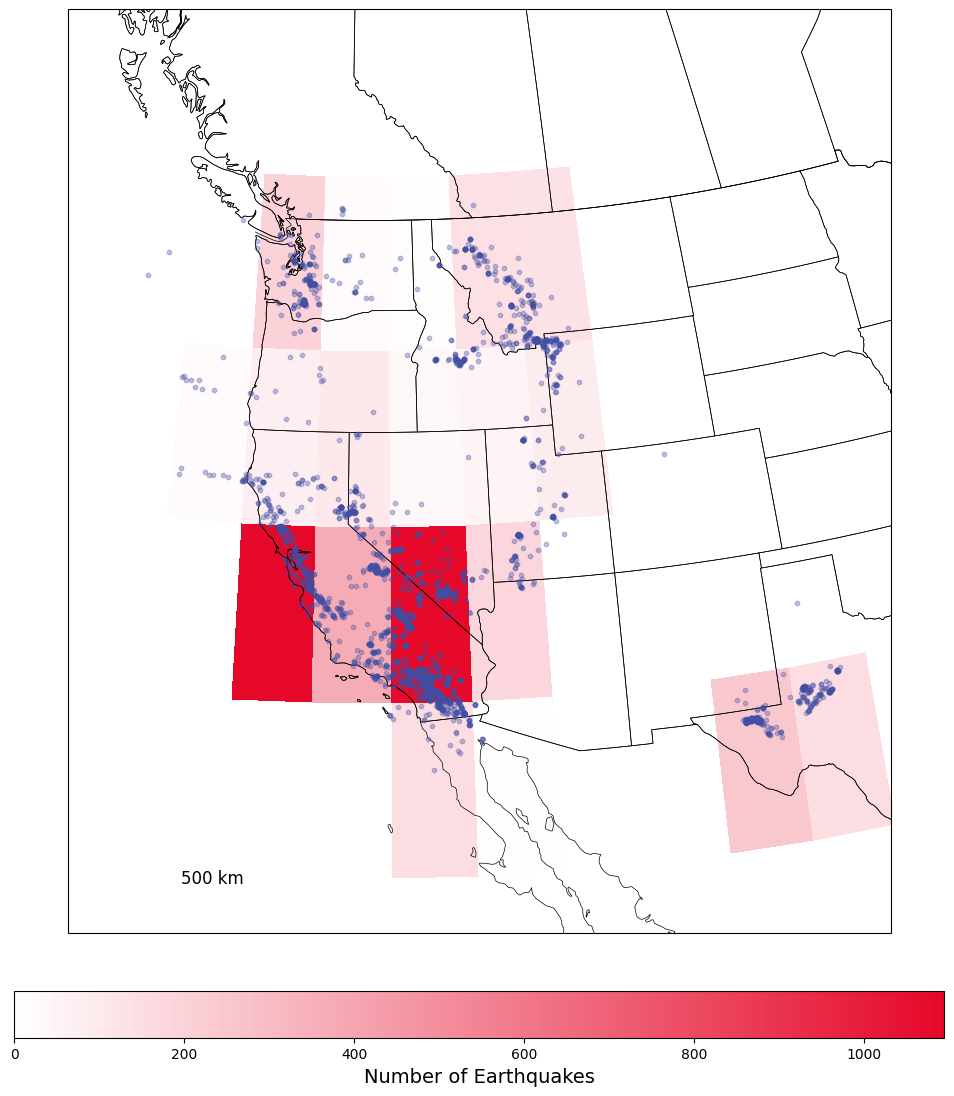

In [ ]:
# sets up Cartopy map projection
proj = ccrs.Orthographic(central_longitude=-119, central_latitude=37)
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection=proj)
ax.set_extent([-130, -100, 25, 55], crs=ccrs.PlateCarree())

# adding features to map
ax.add_feature(cfeat.COASTLINE, linewidth=0.5)
ax.add_feature(cfeat.BORDERS, linewidth=0.5)
ax.add_feature(cfeat.STATES, linewidth=0.5)

# define bins for lat & lon
_db = 1
lon_bins = np.linspace(min(lons) - _db, max(lons) + _db, 10 + 1)
lat_bins = np.linspace(min(lats) - _db, max(lats) + _db, 13 + 1)

# calc density
density, _, _ = np.histogram2d(lats, lons, bins=[lat_bins, lon_bins])

# create meshgrid
lon_bins2d, lat_bins2d = np.meshgrid(lon_bins, lat_bins)

# defining a custom colormap cuz im sweet like that
cdict = {
    "red": ((0.0, 1.0, 1.0), (1.0, 0.9, 1.0)),
    "green": ((0.0, 1.0, 1.0), (1.0, 0.03, 0.0)),
    "blue": ((0.0, 1.0, 1.0), (1.0, 0.16, 0.0)),
}
custom_map = LinearSegmentedColormap("custom_map", cdict)


# plotting the density as a heatmap
heatmap = ax.pcolormesh(
    lon_bins2d, lat_bins2d, density,
    cmap="custom_map",
    transform=ccrs.PlateCarree()
)

cbar = plt.colorbar(heatmap, orientation="horizontal", pad=0.05, shrink=0.8).set_label(
    "Number of Earthquakes", fontsize=14
)

ax.scatter(lons, lats, color = '#424FA4', alpha = .33, s = 10, transform = ccrs.PlateCarree(), zorder = 5)
ax.text(-126, 27, '500 km', transform = ccrs.PlateCarree(), fontsize = 12.)
plt.show()

In [9]:
from matplotlib.patches import Circle
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

In [10]:
data = pl.read_csv("http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv")


In [11]:
data = data.select([
    pl.col("latitude").alias("lat"),
    pl.col("longitude").alias("lon"),
    pl.col("mag").cast(float),
]).filter(pl.col("mag").is_not_null())

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

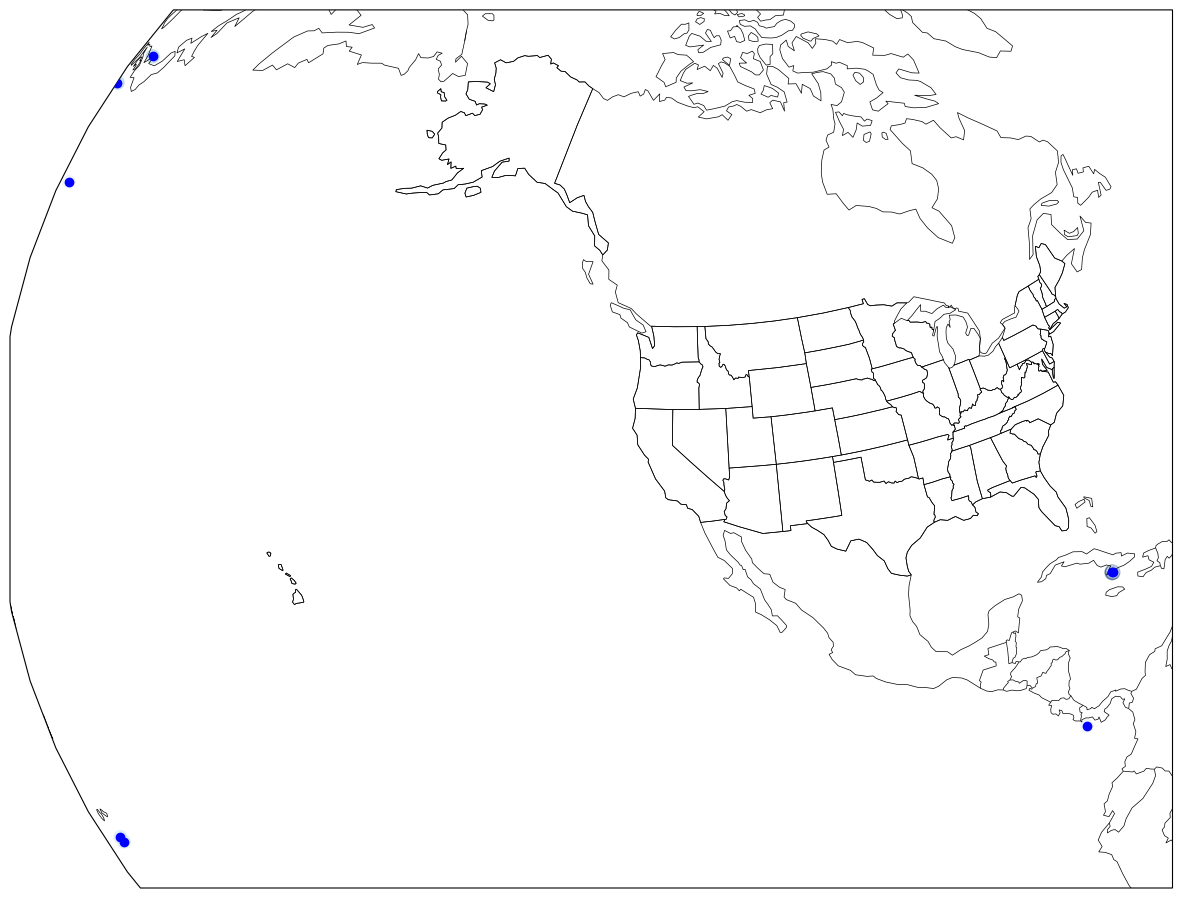

In [16]:
# sort by magnitude & select to top 15 largest earthquakes
top_earthquakes = data.sort("mag", descending=True).head(15)

lats = top_earthquakes["lat"].to_list()
lons = top_earthquakes["lon"].to_list()
magnitudes = top_earthquakes["mag"].to_list()


proj = ccrs.Orthographic(central_longitude=-119, central_latitude=37)
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection=proj)

ax.add_feature(cfeat.COASTLINE, linewidth=0.5)
ax.add_feature(cfeat.BORDERS, linewidth=0.5)
ax.add_feature(cfeat.STATES, linewidth=0.5)

norm = Normalize(vmin=min(magnitudes), vmax=max(magnitudes))
colormap = plt.cm.Blues

# plotting epicenters and adding magnitude circles
for lat, lon, mag in zip(lats, lons, magnitudes):
    # convert lat/long to map coords
    x, y = ax.projection.transform_point(lon, lat, src_crs = ccrs.PlateCarree())
    circle = Circle((x, y), radius = mag*10_000, color = colormap(norm(mag)), alpha = 0.5, transform = ax.transData)
    ax.add_patch(circle)

# scatter plots for epicenters
ax.scatter(lons, lats, color = "blue", transform = ccrs.PlateCarree(), zorder = 5)

# colorbar
sm = ScalarMappable(cmap=colormap, norm=norm)
cbar = plt.colorbar(sm, cax = None, orientation = 'horizontal', pad = 0.05, shrink = 0.8)
cbar.set_label('Earthquake Magnitude', fontsize = 14)
plt.show()
